Load training data (normal operation) and data with faulty operation. 

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.fft import fft, fftfreq
import scipy.io as sio

RAW_FILES = 'raw/'
SENSOR_NAMES = ['X098_FE_time', 'X123_FE_time', 'X190_FE_time', 'X227_FE_time', 
                'X110_FE_time', 'X175_FE_time', 'X214_FE_time', 'X136_FE_time', 
                'X202_FE_time', 'X239_FE_time']
TARGET = 'Fault type'
NORMAL_CONDITION = 'Time_Normal'

files = []
frames = []
column_names = []

for file in os.listdir(RAW_FILES):
    files.append(file)
    raw_dict = sio.loadmat(RAW_FILES + file)  # load raw data file in .mat format
    for i in range(len(SENSOR_NAMES)):
        sensor = SENSOR_NAMES[i]
        if sensor in raw_dict:
            time_series = raw_dict[sensor].flatten()  # extract time series for one of the accelerometers and convert 2D array to 1D array
            sample_points = len(time_series)
            print('Reading file: ' + file)
            print('Number of sample points in file: ' + str(sample_points))

            time_series_df = pd.DataFrame(time_series, columns=[file[:-10]])
            frames.append(time_series_df)
            column_names.append(file[:-10])

all_conditions_df = pd.concat(frames, axis=1, ignore_index=True)
all_conditions_df.to_csv('CWRU_raw_time_series.csv', index=False)
all_conditions_df.columns = column_names

train_df = all_conditions_df[NORMAL_CONDITION]  # get training data which corresponds to time signal during normal operation
train_df.to_csv('AE_train.csv', index=False)

Reading file: B007_1_123.mat
Number of sample points in file: 487384
Reading file: B014_1_190.mat
Number of sample points in file: 486224
Reading file: B021_1_227.mat
Number of sample points in file: 486804
Reading file: IR007_1_110.mat
Number of sample points in file: 486224
Reading file: IR014_1_175.mat
Number of sample points in file: 381890
Reading file: IR021_1_214.mat
Number of sample points in file: 485063
Reading file: OR007_6_1_136.mat
Number of sample points in file: 486804
Reading file: OR014_6_1_202.mat
Number of sample points in file: 484483
Reading file: OR021_6_1_239.mat
Number of sample points in file: 489125
Reading file: Time_Normal_1_098.mat
Number of sample points in file: 483903


In [33]:
train_df.dropna(inplace=True)

index = np.arange(0, len(train_df), 100)
resampled_train_df = train_df[index]

Visualize raw time series for training (normal condition) and all faulty conditions. 

In [34]:
import plotly.express as px

all_conditions_fig = px.line(all_conditions_df, labels={'value': 'Acceleration'}, log_x=True, log_y=True)
# all_conditions_fig.show()

Plot first 500 data points of the raw training time series (normal) in matplotlib for comparison, i.e. to see if there's missing data.

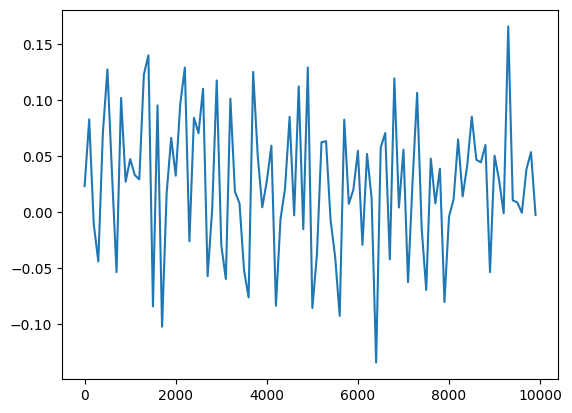

In [46]:
train_df_slice = resampled_train_df.iloc[:100]
plt.plot(train_df_slice)

Create data sequences.

In [37]:
from sklearn.model_selection import train_test_split

TIME_STEPS = 100

x_train, x_test = train_test_split(resampled_train_df, test_size=0.3, random_state=42)

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(x_train)
x_test = create_sequences(x_test)

Reshape input into [samples, timesteps, features].

In [38]:
NFEATURES = 1

x_input = x_train.reshape(x_train.shape[0], x_train.shape[1], NFEATURES)
print("Training input shape after reshaping:", x_train.shape)

Training input shape after reshaping: (3289, 100)


Initialize a PyOD AutoEncoder, fit model to data and make a prediction.

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


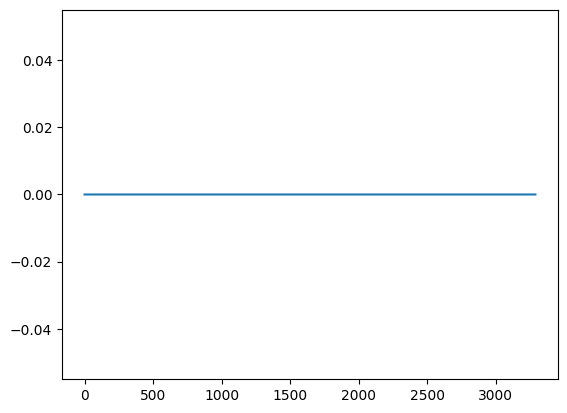

In [56]:
import torch
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import evaluate_print

MODEL_NAME = 'PyOD AutoEncoder'

ae = AutoEncoder(epoch_num=10, contamination=0.00000001)
ae.fit(x_train)

Evaluate model.

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = ae.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = ae.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = ae.predict(x_test)  # outlier labels (0 or 1)
y_test_scores = ae.decision_function(x_test)  # outlier scores

plt.plot(y_train_pred)

# # evaluate and print the results
# print("\nOn Training Data:")
# evaluate_print(MODEL_NAME, y, y_train_scores)
# print("\nOn Test Data:")
# evaluate_print(MODEL_NAME, y_test, y_test_scores)

Create testing dataset that contains anomalies. 

In [ ]:
FAULT_NAME = 'B021'

test_df = 

Define model parameters and inputs.

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed


MODEL_PATH = './models/autoencoder.h5'
MODEL_PARAMETERS = {'LSTM_units_1': 16,
                    'LSTM_units_2': 8,
                    'batch_size': TIME_STEPS,
                    'n_epochs': 20,
                    'optimizer': tf.keras.optimizers.Adam(learning_rate=0.01),
                    'loss': tf.keras.losses.MeanAbsoluteError(),
                    'validation_split': 0.1}

Define model architecture and build model.

In [ ]:
model = Sequential()
model.add(LSTM(units=MODEL_PARAMETERS['LSTM_units_1'], activation='tanh', return_sequences=True, input_shape=(None, NFEATURES)))
model.add(LSTM(units=MODEL_PARAMETERS['LSTM_units_2'], activation='tanh', return_sequences=False))
model.add(RepeatVector(MODEL_PARAMETERS['batch_size']))
model.add(LSTM(units=MODEL_PARAMETERS['LSTM_units_2'], activation='tanh', return_sequences=True))
model.add(LSTM(units=MODEL_PARAMETERS['LSTM_units_1'], activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(NFEATURES, activation='linear')))

model.compile(optimizer=MODEL_PARAMETERS['optimizer'], loss=MODEL_PARAMETERS['loss'])  # Compile model
model.summary()

Train model.

In [ ]:
history = model.fit(x_input, x_input, 
                    epochs=MODEL_PARAMETERS['n_epochs'], 
                    batch_size=MODEL_PARAMETERS['batch_size'], 
                    validation_split=MODEL_PARAMETERS['validation_split'])

model.save(MODEL_PATH)